In [77]:
#Packages

import os
import numpy as np
import time
import random
import pandas as pd
import glob
import shutil
import seaborn as sns
import itertools

from matplotlib.lines import Line2D
from sklearn.metrics import confusion_matrix
from autocatalytic_cores_lib import *
import matplotlib.pyplot as plt
from scipy.stats import linregress


In [106]:
#Parameters definition

ttot = float(100.0) # Total time for the simulation
dt = 1.0E-3 # Timestep

npas = int(ttot//dt)

REALIZATIONS = 50 # Number of simulations

N_X = 3  # Number of species in the original dynamic system
#N_RX = 2  # Number of reactions in the original systems (NOT NEEDED IF X's ARE CONSTANTS)

N_Y = 3   # Number of invaders (must be higher than 3, otherwise I can end up with ambiguity)
N_RY = 4  # Number of reactions for the invaders

In [107]:
# Function to call Praful's code, returning an Excel file with the cores identified

def auto(SM, N_Y):
    n = N_Y

    Excelfile="output/AC_n%d.xlsx"%(n)
    #txtfile="output/AC_n%d.txt"%(n)
    
    df = ComputeAutocatalyticCores(SM, Excelfile)
    return

In [108]:
def stoichio(data, SM, N_Y, N_RY, reverse):
    
    matrices = []

    SM = np.array(SM)
    
    for index, riga in data.iloc[1:].iterrows(): # Spanning among the rows of the Excel file (the rows are the autocatalytic cores)
        indices_N_Y = [i for i, valore in enumerate(riga[(2 + N_Y):(2 + 2*N_Y)]) if valore == 1]   # Save the species that belong to the core
        indices_N_RY = [i for i, valore in enumerate(riga[(2 + 2*N_Y):(2 + 2*N_Y + N_RY + len(reverse))]) if valore == 1]   # Save the reactions that belong to the core
        
        submatrix = SM[np.ix_(indices_N_Y, indices_N_RY)]

        matrices.append(submatrix) # Append all the cores together

    max_eigenvalues = []
    lambs = []
    
    print(f"Eigenvalues for the {len(matrices)} cores:\n")

    def is_metzler(matrix):
   
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                if i != j and matrix[i, j] < 0:
                    return False
        return True

    def permute_to_metzler(matrix):
       
        n = matrix.shape[0]
        row_indices = list(range(n))
        
        for perm in itertools.permutations(row_indices):
            permuted_matrix = matrix[list(perm), :]
            if is_metzler(permuted_matrix):
                return permuted_matrix
        return None


    for matrix in matrices:

        matrix = permute_to_metzler(matrix)
        eigenvalues = np.linalg.eigvals(matrix)

        lambs.append(eigenvalues)
        print(eigenvalues)
        print("\n")

        # Find the maximum eigenvalue
        max_eigenvalue = np.max(eigenvalues)       

        # Add the maximum eigenvalue to the list
        max_eigenvalues.append(max_eigenvalue)

    return max_eigenvalues, matrices, lambs 

In [104]:
# Function to compute a "confusion matrix" to check the percentage of autocatalytic systems which survived among the total number

def confusion(autocatalytics, survival):
    
    auto = [int(x) for x in autocatalytics]   # Takes the outputs of the function "invasion" (cell below) and transform it into boolean variables
    surv = [int(x) for x in survival]

    num_auto = sum(auto) # Total number of autocatalytic realizations
    num_surviving_auto = sum([1 for a, s in zip(auto, surv) if a == 1 and s == 1]) # Total number of surviving AND autocatalytic
    num_non_auto = len(auto) - num_auto # Non autocatalytic realizations
    num_surviving_non_auto = sum([1 for a, s in zip(auto, surv) if a == 0 and s == 1]) # Total number of surviving AND NOT autocatalytic

    
    data = {
        'Category': ['Autocatalytic', 'Non-Autocatalytic'],
        'Non-Surviving Processes': [num_auto, num_non_auto],
        'Surviving Processes': [num_surviving_auto, num_surviving_non_auto]
    }
    df = pd.DataFrame(data) # Table in pd

    plt.figure(figsize=(8, 6))
    sns.barplot(x='Category', y='Non-Surviving Processes', data=df, color='green', label='Non-Surviving Processes')
    sns.barplot(x='Category', y='Surviving Processes', data=df, color='yellow', label='Surviving Processes')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(fontsize=20)  # Dimensione del testo sugli assi x
    plt.yticks(fontsize=20)  # Dimensione del testo sugli assi y
    plt.legend(fontsize=20)  # Dimensione del testo della legenda
    plt.tight_layout()

    # Salvataggio dell'immagine come 'confusion_matrix.png'
    plt.savefig('confusion_matrix_large_dil.pdf', dpi=300)

    plt.show()


    return df


In [109]:
# Main function to check autocatalysis and run simulations  (THE OLDEST VERSION)

def invasion(N_X, N_Y, N_RY, ttot, dt, REALIZATIONS, diluted, ambiguity, law, autonomy):
    
    #Number of steps
    npas = int(ttot / dt)
    
    # Inizialization of compt
    compt = 0
    temps = 0
    
    autocatalytics = []
    survival = []

    if diluted == True and autonomy == False:
        print("Impossible to ask for TOP conditions AND allowing non-autonomy")
        return autocatalytics, survival

    [shutil.rmtree(os.path.join('output', f)) if os.path.isdir(os.path.join('output', f)) else os.unlink(os.path.join('output', f)) for f in os.listdir('output')]
    
    for r in range(REALIZATIONS):

        resY = open("output/Time_%d.dat"%(r + 1), "w")
        resSp = open("output/Stoichio_%d.dat"%(r + 1), "w")

        resY.truncate(0)
        resSp.truncate(0)
    
        S = np.zeros((N_X + N_Y, N_RY))
        #Stoichiometric matrix of the invaders' reactions and for all the species (forward processes)
        S1 = np.zeros((N_X + N_Y, N_RY))
        #Stoichiometric matrix of the invaders' reactions and for all the species (reverse processes)

        # S is the forward matrix (S+) and S1 is the reverse one (S-)
        
        
        X = [2.0 * random.uniform(0.95, 1.05) for _ in range(N_X)] #Initialize constant values for the original species
        Y = [0.0001 * random.uniform(0.95, 1.05) for _ in range(N_Y)] #Initialize constant values for the invader species
    
        kf = [random.uniform(0.95, 1.05) for _ in range(N_RY)] #Initialize constant values for the forward rates
        kr = [random.uniform(0.95, 1.05) for _ in range(N_RY)] #Initialize constant values for the backward rates

        Ytot = sum(Y)

    
        for i in range(N_RY):
                
            total_order_for = random.randint(0, 2)  # Total order for the forward
            total_order_bac = random.randint(0, 2)  # Total order for the backward
            stoichio_for = 0
            stoichio_bac = 0

            
            species1 = random.randint(0, N_Y-1) # There must be at least one Y as reactant
            S[N_X + species1][i] += 1

            if autonomy == True:
                
                species2 = random.randint(0, N_Y-1)
                
                if ambiguity == False:
                    while species2 == species1:
                        species2 = random.randint(0, N_Y-1) # Non-ambiguity condition
                        
                S1[N_X + species2][i] += 1    # There must be at least one Y as product
        
            while(stoichio_for < total_order_for - 1): # Costructing the stoichio forward matrix randomly, up to a total order

                if diluted == False:
                    species = random.randint(0, N_X + N_Y - 1)
                else:
                    species = random.randint(0, N_X  - 1)
                    
                
                if ambiguity == False:
                    if S1[species][i] == 0:  # Non ambiguity
                        S[species][i] += 1
                        stoichio_for += 1
                else:
                    S[species][i] += 1
                    stoichio_for += 1
                    
    
            while(stoichio_bac < (total_order_bac - 1 if autonomy else total_order_bac)): # Costructing the stoichio forward matrix randomly, up to a total order
    
                species = random.randint(0, N_X + N_Y - 1)

                
                if ambiguity == False:
                    if S[species][i] == 0:  # Non ambiguity
                        S1[species][i] += 1
                        stoichio_bac += 1
                else:
                    S1[species][i] += 1
                    stoichio_bac += 1
                
    
        # AUTOCATALYSIS CHECKING
        # Preparing the input for Praful's code splitting the reactions in backward and forward
    
        Sp = (S1 - S)[N_X:][:]
        Stot = S1 - S
        
        new_sp_col = []
        new_stot_col = []
        
        reverse = []

        for index, (sp_col, stot_col, s1_col) in enumerate(zip(Sp.T, Stot.T, S1[N_X:][:].T)):
            if (not diluted and sum(value for value in s1_col if value > 0) >= 1) or (diluted and sum(value for value in s1_col if value > 0) < 2):
                new_sp_col.extend([sp_col, -sp_col])
                new_stot_col.extend([stot_col, -stot_col])
                reverse.append(index)  # Save the index of the reversible reactions
            else:
                new_sp_col.append(sp_col)
                new_stot_col.append(stot_col)      
        
        Sp = np.column_stack(new_sp_col).astype(int)
        Stot = np.column_stack(new_stot_col).astype(int)

    
        auto(Sp, N_Y) # Calling Praful's program
        data = pd.read_excel("output/AC_n%d.xlsx"%(N_Y), header = None) 
    
        if  len(data.iloc[:][0]) > 1:    # Checking the existance of AT LEAST a core in the invaders matrix from the excel output file
    
            print("INVADERS SHOW AUTOCATALYSIS \n \n")

            eigens, matrices, lambs = stoichio(data, Sp, N_Y, N_RY, reverse)

            resSp.write('SHOWS AUTOCATALYSIS \n')
    
            autocatalytics.append(True)
    
        else:
    
            print("NO AUTOCATALYTIC BEHAVIOR \n \n")

            resSp.write("DOESN'T SHOW AUTOCATALYSIS \n")
    
            autocatalytics.append(False)
            
        
        for i in range(npas//100): # Two timescales to print not too much
            
            temps = (i * 100) * dt
            
            print(f"{round(temps,1)} {round(Ytot,3)}", file=resY)
            
            
            for j in range(100):
                
                curr = np.zeros(N_RY)
                rater = kr[:]

                if law == "MAL":

                    ratef = kf[:]
                    
                    for l in range(N_RY):
                        
                        for s, p in zip(np.concatenate((X,Y)), S[:,l]):  # Updating the currents for each reaction each time step
                            ratef[l] *= pow(s, p)
                        for s, p in zip(np.concatenate((X,Y)), S1[:,l]):  # Same but backward
                            rater[l] *= pow(s, p)   
                        if l in reverse:
                            curr[l] = np.array(ratef[l]) - np.array(rater[l])
                        else:
                            curr[l] = np.array(ratef[l])
                            
                if law == "MM":

                    ratef = np.ones(len(kf[:]))

                    for l in range(N_RY):
                        
                        prod = 1
                        
                        for s, p in zip(np.concatenate((X,Y)), S[:,l]):  # Updating the currents for each reaction each time step
                            prod *= pow(s, p)
                        ratef[l] = prod/(kf[l] + prod)
                       
                        for s, p in zip(np.concatenate((X,Y)), S1[:,l]):  # Same but backward
                            rater[l] *= pow(s, p)  

                        if l in reverse:
                            curr[l] = np.array(ratef[l]) - np.array(rater[l])
                        else:
                            curr[l] = np.array(ratef[l])
                    
                    
                
                Y += dt * np.dot((S1 - S), np.array(curr))[N_X:]   # Solving a timestep ODE for the vector of invaders
                Y[Y < 0] = 0 # Non-negativity condition
                
                Ytot = sum(Y)
                
        resSp.write('\n')
        np.savetxt(resSp, Sp, fmt='%d', delimiter=' ', header='', comments='')     # Printing the INVADERS survival matrix in "Stoichio_matrix_Y"
        resSp.write('\n \n')
        np.savetxt(resSp, Stot, fmt='%d', delimiter=' ', header='', comments='') # Printing the WHOLE survival matrix in "Stoichio_matrix_Y"
    
        
        if Ytot >= 0.2: # Threshold for survival
            compt += 1
            
            resSp.write("\n")
            resSp.write('INVADERS GREW')
            
    
            survival.append(True)
    
        else: 
            resSp.write("\n")
            resSp.write("INVADERS DIDN'T GROW")
    
            survival.append(False)

        if  len(data.iloc[:][0]) > 1:
            
            resSp.write('\n\n\n CORES:\n')
            for i in range(len(matrices)):
                np.savetxt(resSp, matrices[i], fmt='%d', delimiter=' ', header='', comments='')
                resSp.write('\n')
            
        resSp.close()
        resY.close()      # Saving and closing the open files
    
    print(f"{compt}/{REALIZATIONS} Realizations led to successful invasion")

    return autocatalytics, survival

In [110]:
autocatalytics,survival = invasion(N_X, N_Y, N_RY, ttot, dt, REALIZATIONS, diluted = True, ambiguity = False, law = "MAL", autonomy = True)

#Species:  3 # Reactions:  8
#Species:  3 # Reactions:  8
Generating Autocatalytic Cycles...


# Autocatalytic Cycles: 0
Consumed Time: 0.00 secs.
Saved in output/AC_n3.xlsx
NO AUTOCATALYTIC BEHAVIOR 
 

#Species:  3 # Reactions:  8
#Species:  3 # Reactions:  8
Generating Autocatalytic Cycles...


# Autocatalytic Cycles: 0
Consumed Time: 0.00 secs.
Saved in output/AC_n3.xlsx
NO AUTOCATALYTIC BEHAVIOR 
 

#Species:  3 # Reactions:  8
#Species:  3 # Reactions:  8
Generating Autocatalytic Cycles...


# Autocatalytic Cycles: 0
Consumed Time: 0.00 secs.
Saved in output/AC_n3.xlsx
NO AUTOCATALYTIC BEHAVIOR 
 

#Species:  3 # Reactions:  8
#Species:  3 # Reactions:  8
Generating Autocatalytic Cycles...


# Autocatalytic Cycles: 0
Consumed Time: 0.00 secs.
Saved in output/AC_n3.xlsx
NO AUTOCATALYTIC BEHAVIOR 
 

#Species:  3 # Reactions:  7
#Species:  3 # Reactions:  7
Generating Autocatalytic Cycles...
**** Sol 1: 3 reactions
	 #Species:  3 #FoodSet:  0 #WasteSet:  0 #ExtraMembersSet:  0 #Rea

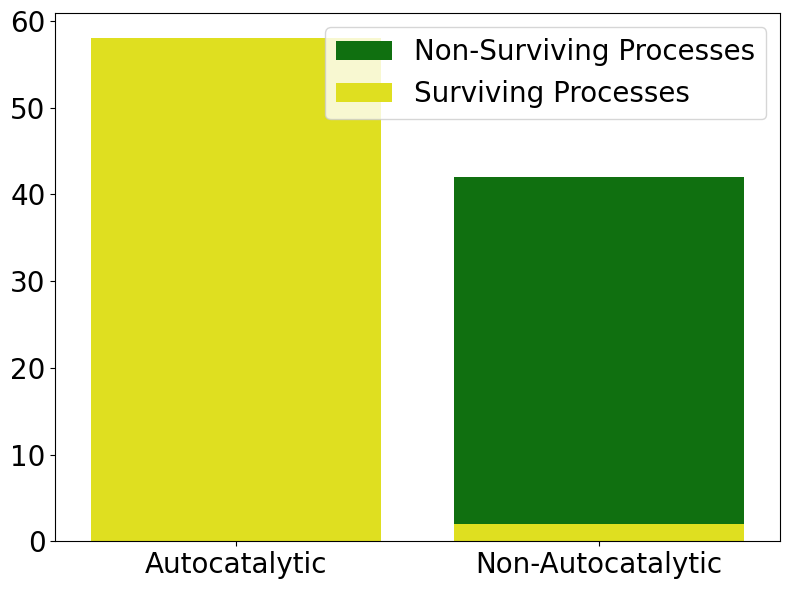

,Category,Non-Surviving Processes,Surviving Processes
0,Autocatalytic,58,58
1,Non-Autocatalytic,42,2


In [105]:
confusion(autocatalytics, survival)

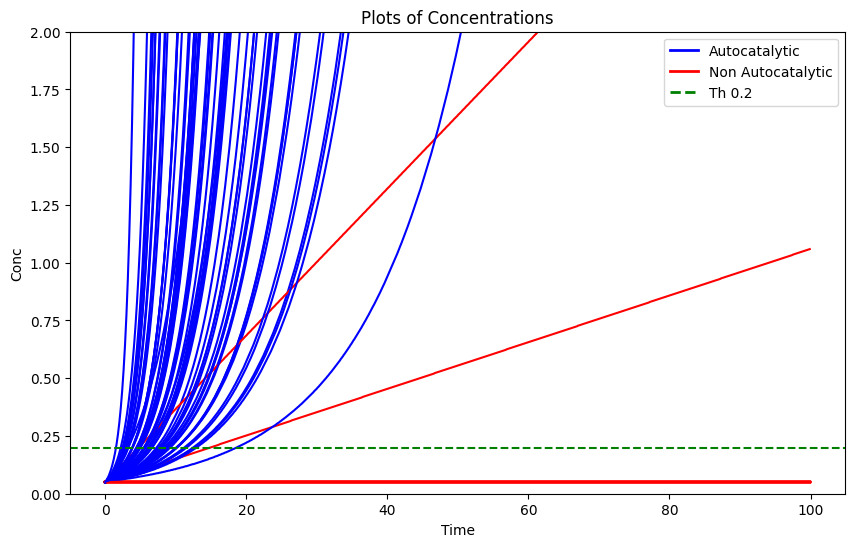

In [103]:
# Specify the folder where to take data
folder_path = "output"

# Finding Time_ files and sort them
file_list = glob.glob(os.path.join(folder_path, "Time_*"))
file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))

plt.figure(figsize=(10, 6))

# Plotting the files based on their autocatalysis
for file, autocatalytic in zip(file_list, autocatalytics):
    
    # Read the DF in pd
    data = pd.read_csv(file, delimiter=' ', header=None, names=['Time', 'Conc'])
    
    # Color based on the autoc
    color = 'blue' if autocatalytic else 'red'
    
    plt.plot(data['Time'], data['Conc'], color=color)

# Adding the threshold
plt.axhline(y=0.2, color='green', linestyle='--', label='Th 0.2')

# Adding labels
plt.title('Plots of Concentrations')
plt.xlabel('Time')
plt.ylabel('Conc')
plt.ylim(0,2)

# Adding a legend for the colors
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Autocatalytic'),
    Line2D([0], [0], color='red', lw=2, label='Non Autocatalytic'),
    Line2D([0], [0], color='green', lw=2, linestyle='--', label='Th 0.2')
]
plt.legend(handles=legend_elements, loc='best')

# Saving and showing
plt.savefig("traj_large_dil.pdf")
plt.show()


In [53]:
for i, (v1, v2) in enumerate(zip(autocatalytics, survival)):
    if v1 != v2:
        print(f"I vettori sono diversi all'indice {i+1}")
        

I vettori sono diversi all'indice 44
I vettori sono diversi all'indice 53
I vettori sono diversi all'indice 74
I vettori sono diversi all'indice 86


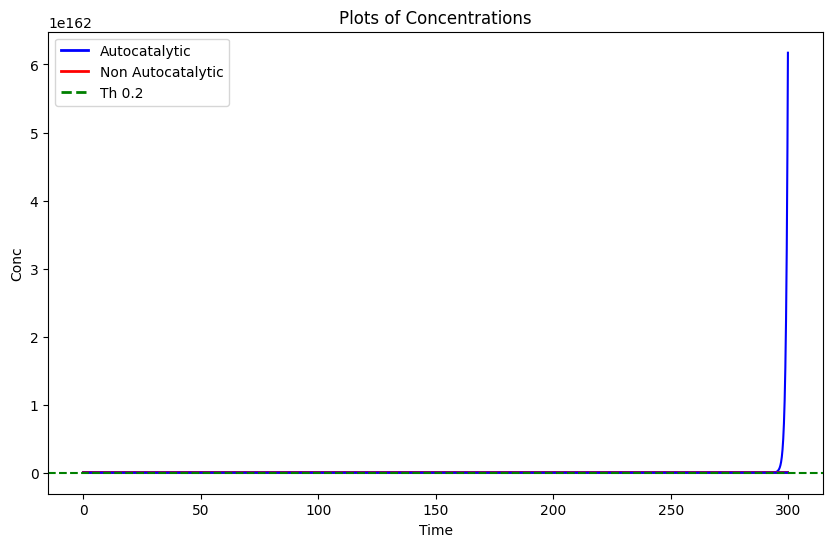

In [19]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

# Specifica la cartella da cui prendere i file
folder_path = "output"

# Trova i file che iniziano con "Time_" nella cartella
file_list = glob.glob(os.path.join(folder_path, "Time_*"))

# Ordina la lista per avere i file ordinati
file_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))

plt.figure(figsize=(10, 6))

# Ciclo attraverso ogni file e plottare i dati con colori diversi in base agli autocatalitici
for file, autocatalytic in zip(file_list, autocatalytics):
    
    # Legge il file in un DataFrame pandas
    data = pd.read_csv(file, delimiter=' ', header=None, names=['Time', 'Conc'])
    
    # Scegli il colore in base alla realizzazione
    color = 'blue' if autocatalytic else 'red'
    
    # Plotta i dati
    plt.plot(data['Time'], data['Conc'], color=color)

# Aggiungi la linea della soglia di sopravvivenza a 0.2
plt.axhline(y=0.2, color='green', linestyle='--', label='Th 0.2')

# Aggiungi titoli e etichette
plt.title('Plots of Concentrations')
plt.xlabel('Time')
plt.ylabel('Conc')

# Aggiungi una legenda manuale per i colori
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Autocatalytic'),
    Line2D([0], [0], color='red', lw=2, label='Non Autocatalytic'),
    Line2D([0], [0], color='green', lw=2, linestyle='--', label='Th 0.2')
]
plt.legend(handles=legend_elements, loc='best')

# Salva il grafico
plt.savefig("traj_dil.pdf")

# Mostra il grafico
plt.show()


In [69]:
# Main function to check autocatalysis and run simulations (OLDER VERSION)

def invasion(N_X, N_Y, N_RY, ttot, dt, REALIZATIONS, degr, strong_prod):

    # degr = True allows degradations as reactions for Y that have more reactants than, products. degr = False allows only irreversible reactions y_i -> y_k + y_j or reversible y_i = y_j

    # strong_prod = True allows products to be always = 2 in their stoichiometry, this is the second condition in Jeremie's paper about autocat <=> survival.

    # NOTE: when degr = True  strong_prod MUST BE = False, when degr = False, strong_prod can be whatever
    
    #Number of steps
    npas = int(ttot / dt)
    
    # Inizialization of compt
    compt = 0
    temps = 0
    
    autocatalytics = []
    survival = []
    
    # The following command removes everything in the output directory
    [shutil.rmtree(os.path.join('output', f)) if os.path.isdir(os.path.join('output', f)) else os.unlink(os.path.join('output', f)) for f in os.listdir('output')]
    
    for r in range(REALIZATIONS):

        resY = open("output/Time_%d.dat"%(r + 1), "w")     # Opens the file for the single realization (Time series)
        resSp = open("output/Stoichio_%d.dat"%(r + 1), "w")  # Opens the file for the single realization (Stoichio matrix)

        resY.truncate(0)
        resSp.truncate(0)
    
        S = np.zeros((N_X + N_Y, N_RY))
        #Stoichiometric matrix of the invaders' reactions and for all the species (forward processes)
        S1 = np.zeros((N_X + N_Y, N_RY))
        #Stoichiometric matrix of the invaders' reactions and for all the species (reverse processes)

        # S is the forward matrix (S+) and S1 is the reverse one (S-)
        
        
        X = [2.0 * random.uniform(0.95, 1.05) for _ in range(N_X)] #Initialize constant values for the original species
        Y = [0.01 * random.uniform(0.95, 1.05) for _ in range(N_Y)] #Initialize constant values for the invader species
    
        kf = [random.uniform(0.95, 1.05) for _ in range(N_RY)] #Initialize constant values for the forward rates
        kr = [random.uniform(0.95, 1.05) for _ in range(N_RY)] #Initialize constant values for the backward rates

        Ytot = sum(Y)

    
        for i in range(N_RY):
                
            total_order_for = random.randint(0, 2)  # Total order for the forward
            total_order_bac = random.randint(0, 2)  # Total order for the backward
            stoichio_for = 0
            stoichio_bac = 0
    
            species1 = random.randint(0, N_Y-1) # There must be at least one Y as reactant
            S[N_X + species1][i] += 1
            
            species2 = random.randint(0, N_Y-1)  # There must to be at least one Y as product
            while species2 == species1:
                species2 = random.randint(0, N_Y-1)  # Non ambiguity for the needed reactant and product
            S1[N_X + species2][i] += 1
        
            while(stoichio_for < total_order_for - 1): # Costructing the stoichio forward matrix randomly, up to a total order

                if degr == True:           # If we ask for degradation allowed or for strong production NOT allowed, then it's ok to have more Y's as reactants
                    species = random.randint(0, N_X + N_Y - 1)
                
                else:
                    species = random.randint(0, N_X  - 1)         # But if we don't want degradation or I want strong production, then I MUST HAVE JUST ONE Y as reactant, which was aready selected above
                    
                
                if S1[species][i] == 0:  # Non ambiguity for the new added species, checking they were not taken as products at the beginning
                    S[species][i] += 1
                    stoichio_for += 1
                
            species2 += N_X # It was drawn from only Y's, now I need it to give the correct index back
            
            while(stoichio_bac < total_order_bac - 1): # Costructing the stoichio backward randomly, up to a total order

            
                species = random.randint(0, N_X + N_Y - 1)    # Here you can take whatever reactant, is not constrained
                
                if strong_prod == False:    # If I don't want strong production, then I don't need high stoichiometric coefficients
                    
                    if S[species][i] == 0:  # Non ambiguity
                        S1[species][i] += 1
                        stoichio_bac += 1
                        
                else:
                    
                    if species < N_X - 1: # If I want strong production, this has to be ONLY for Y species
                        if S[species][i] == 0:  # Non ambiguity
                            S1[species][i] += 1
                            stoichio_bac += 1
                    else:
                        
                        if S1[species2][i] < 2: 
                            S1[species2][i] += 1  # Before adding new Y's species I have to increase the one which was already a product for sure
                            stoichio_bac += 1

                        if S[species][i] == 0 and species != species2:  # Non ambiguity
                            S1[species][i] += 2  # Strong production (Jeremie's TOP theorem)
                            stoichio_bac += 2
                        
    
        # AUTOCATALYSIS CHECKING
        # Preparing the input for Praful's code splitting the reactions in backward and forward
    
        Sp = (S1 - S)[N_X:][:]  # Matrix for Invaders
        Stot = S1 - S  # Whole matrix
        
        new_sp_col = []
        new_stot_col = []
        
        for sp_col, stot_col in zip(Sp.T, Stot.T):
            
            if degr == True or sum(value for value in sp_col if value > 0) < 2:  # Reverse the reactions ONLY if you admit degradation or if there is just one Y as product (TOP's first reaction holds)
                new_sp_col.extend([sp_col, -sp_col])
                new_stot_col.extend([stot_col, -stot_col])
                
            else:
                new_sp_col.append(sp_col) # Otherwise leave the reaction to be irreversible
                new_stot_col.append(stot_col)
                
                
        
        Sp = np.column_stack(new_sp_col).astype(int)      # Matrices updated to have reversible or not reversible reactions according to TOP with strong or not strong degradation
        Stot = np.column_stack(new_stot_col).astype(int)

    
        auto(Sp, N_Y) # Calling Praful's program
        data = pd.read_excel("output/AC_n%d.xlsx"%(N_Y), header = None) 
    
        if  len(data.iloc[:][0]) > 1:    # Checking the existance of AT LEAST a core in the invaders matrix from the excel output file
    
            print("INVADERS SHOW AUTOCATALYSIS \n \n")

            resSp.write('SHOWS AUTOCATALYSIS \n')
    
            autocatalytics.append(True)
    
        else:
    
            print("NO AUTOCATALYTIC BEHAVIOR \n \n")

            resSp.write("DOESN'T SHOW AUTOCATALYSIS \n")
    
            autocatalytics.append(False)
            
        
        for i in range(npas//100): # Two timescales to print not too much
            
            temps = (i * 100) * dt
            
            print(f"{round(temps,1)} {round(Ytot,3)}", file=resY)
            
            for j in range(100):

                ratef = kf[:]
                rater = kr[:]
                
                for l in range(N_RY):
                    
                    for s, p in zip(np.concatenate((X,Y)), S[:,l]):  # Updating the currents for each reaction each time step
                        ratef[l] *= pow(s, p)
                    for s, p in zip(np.concatenate((X,Y)), S1[:,l]):  # Same but backward
                        rater[l] *= pow(s, p)   
                    
                
                Y += dt * np.dot((S1 - S), (np.array(ratef) - np.array(rater)))[N_X:]   # Solving a timestep ODE for the vector of invaders
                Y[Y < 0] = 0 # Non-negativity condition
                
                Ytot = sum(Y)

        resSp.write('\n')
        np.savetxt(resSp, Sp, fmt='%d', delimiter=' ', header='', comments='')     # Printing the INVADERS survival matrix in "Stoichio_matrix_Y"
        resSp.write('\n \n')
        np.savetxt(resSp, Stot, fmt='%d', delimiter=' ', header='', comments='') # Printing the WHOLE survival matrix in "Stoichio_matrix_Y"
    
        
        if Ytot >= 0.2: # Threshold for survival
            compt += 1
            
            resSp.write("\n")
            resSp.write('INVADERS GREW')
            
    
            survival.append(True)
    
        else: 
            resSp.write("\n")
            resSp.write("INVADERS DIDN'T GROW")
    
            survival.append(False)
            
        resSp.close()
        resY.close()      # Saving and closing the open files
    
    print(f"{compt}/{REALIZATIONS} Realizations led to successful invasion")

    return autocatalytics, survival

In [441]:
# Main function to check autocatalysis and run simulations  (THE OLDEST VERSION)

def invasion(N_X, N_Y, N_RY, ttot, dt, REALIZATIONS, degr):
    
    #Number of steps
    npas = int(ttot / dt)
    
    # Inizialization of compt
    compt = 0
    temps = 0
    
    autocatalytics = []
    survival = []

    [shutil.rmtree(os.path.join('output', f)) if os.path.isdir(os.path.join('output', f)) else os.unlink(os.path.join('output', f)) for f in os.listdir('output')]
    
    for r in range(REALIZATIONS):

        resY = open("output/Time_%d.dat"%(r + 1), "w")
        resSp = open("output/Stoichio_%d.dat"%(r + 1), "w")

        resY.truncate(0)
        resSp.truncate(0)
    
        S = np.zeros((N_X + N_Y, N_RY))
        #Stoichiometric matrix of the invaders' reactions and for all the species (forward processes)
        S1 = np.zeros((N_X + N_Y, N_RY))
        #Stoichiometric matrix of the invaders' reactions and for all the species (reverse processes)

        # S is the forward matrix (S+) and S1 is the reverse one (S-)
        
        
        X = [2.0 * random.uniform(0.95, 1.05) for _ in range(N_X)] #Initialize constant values for the original species
        Y = [0.01 * random.uniform(0.95, 1.05) for _ in range(N_Y)] #Initialize constant values for the invader species
    
        kf = [random.uniform(0.95, 1.05) for _ in range(N_RY)] #Initialize constant values for the forward rates
        kr = [random.uniform(0.95, 1.05) for _ in range(N_RY)] #Initialize constant values for the backward rates

        Ytot = sum(Y)

    
        for i in range(N_RY):
                
            total_order_for = random.randint(0, 2)  # Total order for the forward
            total_order_bac = random.randint(0, 2)  # Total order for the backward
            stoichio_for = 0
            stoichio_bac = 0
    
            species1 = random.randint(0, N_Y-1) # There must be at least one Y as reactant
            S[N_X + species1][i] += 1
            species2 = random.randint(0, N_Y-1)
            while species2 == species1:
                species2 = random.randint(0, N_Y-1) # There must to be at least one Y as product
            S1[N_X + species2][i] += 1
        
            while(stoichio_for < total_order_for - 1): # Costructing the stoichio forward matrix randomly, up to a total order

                if degr == True:
                    species = random.randint(0, N_X + N_Y - 1)
                else:
                    species = random.randint(0, N_X  - 1)
                    
                
                if S1[species][i] == 0:  # Non ambiguity
                    S[species][i] += 1
                    stoichio_for += 1
    
            while(stoichio_bac < total_order_bac - 1): # Costructing the stoichio forward matrix randomly, up to a total order
    
                species = random.randint(0, N_X + N_Y - 1)
                
                if S[species][i] == 0:  # Non ambiguity
                    S1[species][i] += 1
                    stoichio_bac += 1
    
        # AUTOCATALYSIS CHECKING
        # Preparing the input for Praful's code splitting the reactions in backward and forward
    
        Sp = (S1 - S)[N_X:][:]
        Stot = S1 - S
        
        new_sp_col = []
        new_stot_col = []
        
        for sp_col, stot_col in zip(Sp.T, Stot.T):
            
            if degr == True or sum(value for value in sp_col if value > 0) < 2:
                new_sp_col.extend([sp_col, -sp_col])
                new_stot_col.extend([stot_col, -stot_col])
                
            else:
                new_sp_col.append(sp_col)
                new_stot_col.append(stot_col)
                
                
        
        Sp = np.column_stack(new_sp_col).astype(int)
        Stot = np.column_stack(new_stot_col).astype(int)

    
        auto(Sp, N_Y) # Calling Praful's program
        data = pd.read_excel("output/AC_n%d.xlsx"%(N_Y), header = None) 
    
        if  len(data.iloc[:][0]) > 1:    # Checking the existance of AT LEAST a core in the invaders matrix from the excel output file
    
            print("INVADERS SHOW AUTOCATALYSIS \n \n")

            resSp.write('SHOWS AUTOCATALYSIS \n')
    
            autocatalytics.append(True)
    
        else:
    
            print("NO AUTOCATALYTIC BEHAVIOR \n \n")

            resSp.write("DOESN'T SHOW AUTOCATALYSIS \n")
    
            autocatalytics.append(False)
            
        
        for i in range(npas//100): # Two timescales to print not too much
            
            temps = (i * 100) * dt
            
            print(f"{round(temps,1)} {round(Ytot,3)}", file=resY)
            
            for j in range(100):

                ratef = kf[:]
                rater = kr[:]
                
                for l in range(N_RY):
                    
                    for s, p in zip(np.concatenate((X,Y)), S[:,l]):  # Updating the currents for each reaction each time step
                        ratef[l] *= pow(s, p)
                    for s, p in zip(np.concatenate((X,Y)), S1[:,l]):  # Same but backward
                        rater[l] *= pow(s, p)   
                    
                
                Y += dt * np.dot((S1 - S), (np.array(ratef) - np.array(rater)))[N_X:]   # Solving a timestep ODE for the vector of invaders
                Y[Y < 0] = 0 # Non-negativity condition
                
                Ytot = sum(Y)

        resSp.write('\n')
        np.savetxt(resSp, Sp, fmt='%d', delimiter=' ', header='', comments='')     # Printing the INVADERS survival matrix in "Stoichio_matrix_Y"
        resSp.write('\n \n')
        np.savetxt(resSp, Stot, fmt='%d', delimiter=' ', header='', comments='') # Printing the WHOLE survival matrix in "Stoichio_matrix_Y"
    
        
        if Ytot >= 0.2: # Threshold for survival
            compt += 1
            
            resSp.write("\n")
            resSp.write('INVADERS GREW')
            
    
            survival.append(True)
    
        else: 
            resSp.write("\n")
            resSp.write("INVADERS DIDN'T GROW")
    
            survival.append(False)
            
        resSp.close()
        resY.close()      # Saving and closing the open files
    
    print(f"{compt}/{REALIZATIONS} Realizations led to successful invasion")

    return autocatalytics, survival